**DeepDream is an experiment that visualizes the patterns learned by the neural network.** Similar to when a child watches clouds and tries to interpret them as random shapes. **DeepDream over-interprets and enhances the patterns it sees in an image.**

It does so by forwarding an image through the model, then calculate the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the model, and result in a dream-like image. This process was dubbed `inceptionism`.

Let's demonstrate how you can make a neural network `dream` and enhance the patterns it sees in an image.

![](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

(Refer to Tensorflow.org (2020))

In [0]:
!pip uninstall -y tensorflow
!pip install -q --no-cache-dir tf-nightly

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200415
GPU is available.


# Choose an image to dreamify

In [0]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [0]:
# Download the image and read it into a numpy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(fname=name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

In [0]:
# show the image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

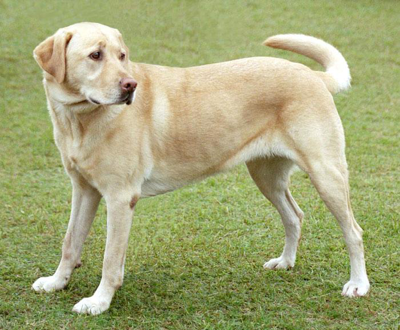

In [8]:
original_img = download(url, max_dim=400)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [0]:
# de-normalize the image
def deprocess(img):
  """deprocess process the image back into the scale from 0 to 255.
  
  Args:
    img: a numpy array scaled in the range from -1.0 to 1.0
  Returns:
    img: a unsigned int8 image
  """
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

# Prepare the feature extraction model

Download and prepare a pre-trained image classification model. Here you are going to use `InceptionV3` that is similar to the model originally used in DeepDream.

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [11]:
for layer in base_model.layers:
  if layer.name[:5] == "mixed":
    print("{:<25s}: {}".format(layer.name, layer.output_shape))

mixed0                   : (None, None, None, 256)
mixed1                   : (None, None, None, 288)
mixed2                   : (None, None, None, 288)
mixed3                   : (None, None, None, 768)
mixed4                   : (None, None, None, 768)
mixed5                   : (None, None, None, 768)
mixed6                   : (None, None, None, 768)
mixed7                   : (None, None, None, 768)
mixed8                   : (None, None, None, 1280)
mixed9_0                 : (None, None, None, 768)
mixed9                   : (None, None, None, 2048)
mixed9_1                 : (None, None, None, 768)
mixed10                  : (None, None, None, 2048)


The idea in DeepDream is to choose layers and maximum the `loss` in a way that the image increasingly `excites` the layers. The complexity of the features incorporated depends on the layers you chose. The lower layer produces strokes or simple patterns, while the higher layer produces sophisticated features in images or even the whole object. 

The Inception model is a complex and large architecture. For DeepDream, the layers of the interest are those where the convolution layers are concatenated. In the InceptionV3 model, there are 11 layers that are through `mixed0` to `mixed10`. You will get different results while using different layers. The lower layer would produce elementary features, while the higher layer would produce combined features or even the whole object.

In [12]:
# maximize the activations of these layers
names = ['mixed3', 'mixed7']
layers = [base_model.get_layer(name=name).output for name in names]
layers

[<tf.Tensor 'mixed3/Identity:0' shape=(None, None, None, 768) dtype=float32>,
 <tf.Tensor 'mixed7/Identity:0' shape=(None, None, None, 768) dtype=float32>]

In [13]:
# create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is also normalized at each layer so that the contribution from higher layers does not outweigh the lower layers. In general, the loss is a quantity that you are trying to minimize it via gradient descent, in DeepDream you will maximum the loss value via gradient ascent.

In [0]:
def cal_loss(img, model):
  """
  Args:
    img: a tensor in shape of (height, width, channels)
    model: a tf.keras model

  Returns:
    a loss value in float
  """
  img_batch = tf.expand_dims(img, axis=0)  # [bs, height, width, channels]
  act_layers = model(img_batch)            # [[act_layer_1], [act_layer_2]] or [act_layer_1]
  if len(act_layers) == 1:
    # make sure the act_layers in the shape of [[act_layer_1]]
    # while there is only one activation layer
    act_layers = [act_layers]

  losses = []
  for layer in act_layers:
    loss = tf.math.reduce_mean(layer)
    losses.append(loss)
  return tf.reduce_sum(losses)

# Gradient Ascent

After you calculate the loss of the chosen layers, the next step is to calculate the gradients with respect to the image and add gradients to the original image.

Adding the gradients to the image enhances the patterns seen by the model. At each training step, you will create an image that increasingly excites the activations of the certain layers in the model.

The method of calculating the gradient ascent is wrapped with a `tf.function` for performance. It also uses an `input_signature` to ensure that the function is not retraced for different image shapes, steps or step_size values.

In [0]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.int32),
      tf.TensorSpec(shape=[], dtype=tf.float32),
    )
  )
  def __call__(self, img, step, step_size):
    """
    Args:
      img: a tensor in the shape of (height, width, channels), not a tf.Variable

    Returns:
      loss value
      an excited image
    """
    loss = tf.constant(0.0)
    for _ in tf.range(step):
      with tf.GradientTape() as tape:
        # this needs gradients relative to the `img`
        # the GradientTape watches the tf.Variable by default
        tape.watch(img)
        loss = cal_loss(img, self.model)
      
      # calculate the gradients with respect to the pixels of the image
      gradients = tape.gradient(loss, img)

      # normalize the gradients
      gradients /= tf.math.reduce_std(gradients) + 1e-6

      # in gradient ascent, the `loss` is maximized so that the input image 
      # increasingly excites the layers.
      # this similiar to the gradient descent
      # step_size is like learning_rate
      img = img + gradients * step_size
      img = tf.clip_by_value(t=img, clip_value_min=-1.0, clip_value_max=1.0)
    
    return loss, img

In [0]:
deepdream = DeepDream(model=dream_model)

# Main Loop

In [0]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # convert the img and values into tensors
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(value=img)

  remaining_step = steps
  step = 0
  while remaining_step:
    if remaining_step > 100:
      # each time calls DeepDream module, the step is 100 at most
      run_step = 100
    else:
      run_step = remaining_step
    remaining_step -= run_step
    step += run_step

    loss, img = deepdream(img, tf.constant(run_step), tf.constant(step_size))

    display.clear_output(wait=True)
    show(img=deprocess(img))
    print("Step {}, Loss {}".format(step, loss))

  display.clear_output(wait=True)
  result = deprocess(img)
  show(img=result)

  return result  

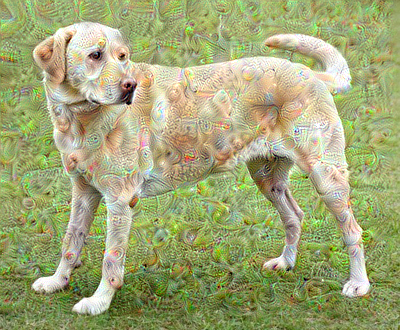

In [18]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=1e-2)

# Taking it up an octave

After the first attempt, there are several issues.
* The output is noisy. (this is addressed using the `tf.image.total_variation` loss.)
* The image is low resolution.
* The patterns appear they are all happening at the same granularity.

One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional details.

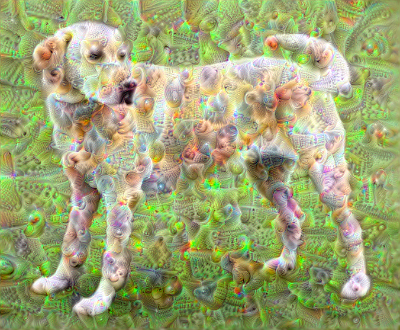

In [19]:
OCTAVE_SCALE = 1.30

img = tf.constant(value=original_img)
base_shape = tf.shape(img)[:-1]
float_shape = tf.cast(base_shape, dtype=tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_shape * (OCTAVE_SCALE ** n), dtype=tf.int32)
  img = tf.image.resize(img, size=new_shape).numpy()
  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, size=base_shape).numpy()
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

# Scaling up with tiles

The octave approach helps to increasingly excite the activation of specific layers. It still remains some problems. 
* The above approach will not work on a very large image or many octaves.
* The above approach requires lots of resources.

To avoid these issues, you can split the image into tiles and compute the gradient for each tile.

You first apply random shifts to the image before each tiled computation to prevent tile seams from appearing.

In [0]:
def random_roll(img, max_roll):
  shift = tf.random.uniform(shape=[2], minval=-max_roll, maxval=max_roll, dtype=tf.int32)
  shift_down, shift_right = shift[0], shift[1]
  img = tf.roll(input=tf.roll(input=img, shift=shift_down, axis=0),
                shift=shift_right,
                axis=1)
  return shift_down, shift_right, img

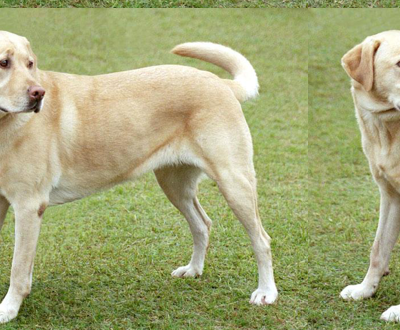

In [21]:
shift_dwon, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [0]:
class TileGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.int32)
    )
  )
  def __call__(self, img, tile_size=512):
    # roll an image randomly
    shift_down, shift_right, rolled_img = random_roll(img=img, max_roll=tile_size)

    # initialize the image gradients to zero
    gradients = tf.zeros_like(input=img)

    # skip the last tile, unless there's only one tile
    ys = tf.range(0, tf.shape(rolled_img)[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])
    
    xs = tf.range(0, tf.shape(rolled_img)[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])

    for y in ys:
      for x in xs:
        with tf.GradientTape() as tape:
          tape.watch(rolled_img)

          # extract a tile out of the image
          img_tile = rolled_img[y:y+tile_size, x:x+tile_size, ...]
          loss = cal_loss(img=img_tile, model=self.model)
        
        # update the gradients for this tile
        gradients += tape.gradient(loss, rolled_img)
    
    # undo the random rolling
    gradients = tf.roll(tf.roll(gradients, shift=-shift_right, axis=1), 
                        shift=-shift_down,
                        axis=0)
    
    # normalize the gradients
    gradients /= tf.math.reduce_std(gradients) + 1e-6
    return gradients

In [0]:
tiled_gradients = TileGradients(model=dream_model)

Putting the new TileGradients and octave-aware together to give a scalable DeepDream implementation.

In [0]:
def run_deep_dream_with_octaves(img, step_per_octave=100, step_size=0.01, 
                                octaves=range(-2, 3), octave_scale=1.3):
  base_shape = tf.shape(img)[:-1]
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.image.resize(images=img, size=base_shape)

  for octave in octaves:
    new_shape = tf.cast(tf.cast(base_shape, tf.float32) * (octave_scale ** octave), tf.int32)
    img = tf.image.resize(images=img, size=new_shape)

    for step in range(step_per_octave):
      gradients = tiled_gradients(img=img, tile_size=512)
      img += gradients * step_size
      img = tf.clip_by_value(img, clip_value_min=-1., clip_value_max=1.)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Octave: {}".format(octave))

  result = deprocess(img)
  return result

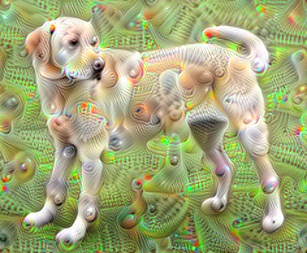

Octave: -1


In [0]:
result = run_deep_dream_with_octaves(img=original_img)
result = tf.image.resize(result, size=base_shape)
result = tf.image.convert_image_dtype(result/255.0, dtype=tf.uint8)
display.clear_output(wait=True)
show(result)